## Tweet Sentiment Analysis Using Natural Language Processing

With the proliferation of social media platforms like Twitter, the expression of diverse opinions and sentiments has become more accessible than ever before. However, alongside this freedom of expression, there has been an increase in the prevalence of offensive and abusive content (Jiang and Suzuki, 2019), posing challenges for platform moderators, users, and society at large.

In this experiment, the task is to develop and evaluate machine learning models for the identification and classification of posts on Twitter into three classes: non-insultive posts, untargeted insults, and targeted insults. This research aims to address the critical need for automated methods to detect and categorise offensive language and behavior on social media platforms like Twitter. By accurately classifying posts into these classes, the study seeks to contribute to the development of effective strategies for managing and mitigating online harassment and abuse.



To begin the experiment, relevant python libraries were imported. These libraries included python libraries  for data preprocessing, machine learning algorithm, libraries for model evaluation, and libraries for data manipulation and plotting.

In [3]:
import nltk
nltk.download('punkt')  # NLTK module required for Tokenizers
!pip install emoji
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from nltk.stem import PorterStemmer
nltk.download('wordnet')  # NLTK module required for WordNetLemmatizer
nltk.download('omw-1.4') # NLTK module required for WordNetLemmatizer

from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
import en_core_web_sm  # spacy model
nlp = en_core_web_sm.load()
nlp.add_pipe("merge_entities")
nltk.download('stopwords')
from imblearn.over_sampling import SMOTE

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# libraries for ML algorithms
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
import emoji

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.3 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Data Description**

The data consist of tweets from tweeter and has three columns- Id, tweet and label and 13240 rows. The label is categorised by NOT- Not insult, UNT- Untargeted insult and TIN- Targeted insult. It was observed that the data had no missing entries.

In [4]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(13240, 3)


,id,tweet,label
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [5]:
#handling missing columns
df = df.dropna()
print(f'Number of entries: {len(df)}')

Number of entries: 13240


In [6]:
df.describe()

,id
count,13240.000000
mean,54881.766163
std,26092.681658
min,10006.000000
25%,32235.750000
50%,54852.000000
75%,77743.250000
max,99986.000000


In [7]:
df.shape

(13240, 3)

The distribution of labels in the tweet sentiment analysis data suggests that a significant portion of the tweets are categorised as "not insult," comprising approximately 66.8% of the dataset. On the other hand, "targeted insult" tweets account for around 29.3% of the data, while "untargeted insult" tweets make up only about 4% of the dataset.
It is possible that the distribution of sentiments (not insult, targeted insult, untargeted insult) in the dataset mirrors the natural distribution of sentiments in real-world tweets. This could indicate that the majority of tweets are non-insulting, with a smaller percentage being targeted insults and a much smaller percentage being untargeted insults.

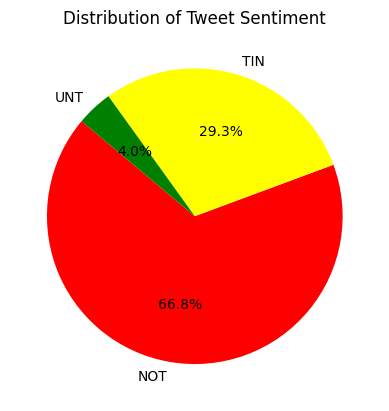

In [8]:
label = df['label'].value_counts()

# Creating the pie chart
plt.pie(label, labels=label.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Distribution of Tweet Sentiment')
plt.show()

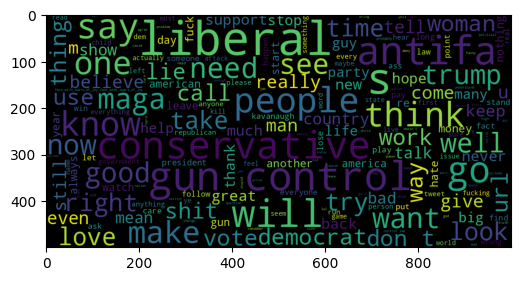

In [25]:
from wordcloud import WordCloud
allwords=''.join([i for i in df['removed_punctuation']])
cloud=WordCloud(width=1000,height=500,random_state=42,max_font_size=100).generate(allwords)

plt.figure(figsize=(6, 4), dpi=100)
plt.imshow(cloud)
plt.show()

In this word cloud above, it is shown that the words in these tweets focuses on political discourse, with discussions revolving around ideological differences, policy debates, political figures, and expressions of opinion.

Text(0.5, 1.0, 'Kernel Distribution of Number Of words')

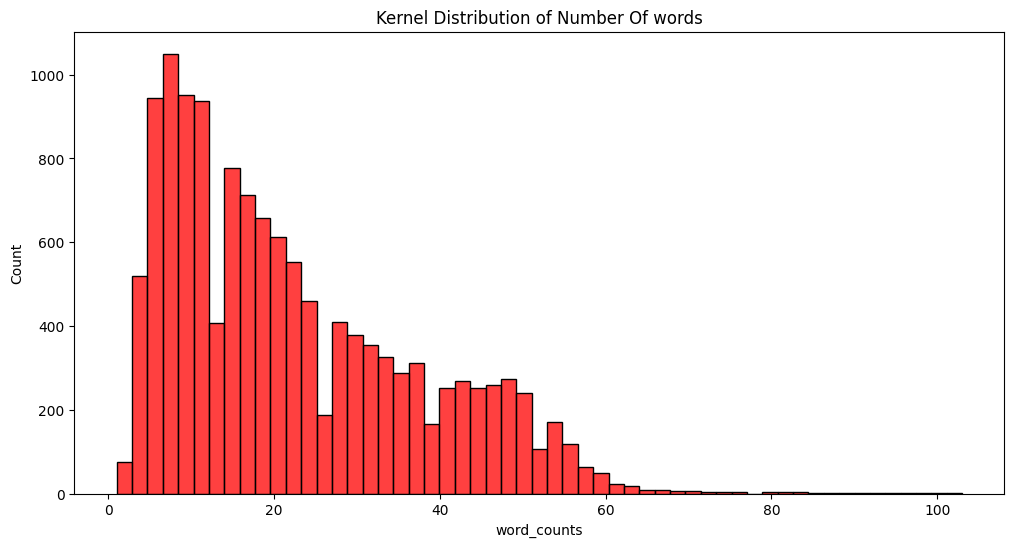

In [27]:
word_counts = df['tweet'].str.split().apply(len)

# Add a new column to the DataFrame containing the word count for each tweet
df['word_counts'] = word_counts

plt.figure(figsize=(12,6))
sns.histplot(df['word_counts'], fill=True, color="r").set_title('Kernel Distribution of Number Of words')

The plot above showed that most tweets had word count between 8 and 20.  This shows that most of the tweets captures attention and fosters interaction but may present a chalange of failure to express complex idea and convey expressive information in these short tweets.

### **Data Preprocessing Techniques**

To improve the quality and effectiveness of the sentiment analysis task, some preprocessing techniques were done on the data. This include tweet tokenisation, lemmatisation, removing special characters and punctuations and handling of emojis.

In [10]:
def tokenize_tweet(df):
  tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
  list_tokenised_text = [tknzr.tokenize(text) for text in df['tweet']]
  df["tokenised_text"] = [' '.join(tokens) for tokens in list_tokenised_text]
  list_lemmatised_sentences = []
  for tokens in df["tokenised_text"]:
    lemma_words = nlp(tokens)
    list_lemmatised_sentences.append(" ".join([token.lemma_ for token in lemma_words]))
  df["list_lemmatised_sentences"] = list_lemmatised_sentences



Tokenization is the process of breaking down the text into individual tokens or words. In the case of this experiment which involves tweet data, tweet tokenization was used (Mahata et al, 2019).

In [11]:
tokenize_tweet(df)

### **Lemmatisation**
Lemmatisation is a technique used to reduce words to their base or root forms. Lemmatisation maps words to their dictionary form (lemma). This helps standardize word representation and improve analysis accuracy. Lemmatisation is widely used in NLP and is proven to have great results (Tabassum and Patil, 2020).

In [12]:
df.head()

,id,tweet,label,tokenised_text,list_lemmatised_sentences
0,86426,@USER She should ask a few native Americans wh...,UNT,she should ask a few native americans what the...,she should ask a few native americans what the...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN,go home you ’ re drunk ! ! ! #maga #trump2020 ...,go home you ' re drunk ! ! ! #maga # trump2020...
2,16820,Amazon is investigating Chinese employees who ...,NOT,amazon is investigating chinese employees who ...,amazon be investigate chinese employee who be ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT,"someone should'vetaken "" this piece of shit to...","someone should'vetaken "" this piece of shit to..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,obama wanted liberals & illegals to move into ...,obama want liberal & illegal to move into red ...


### **Emoji Handling**

Emojis and emoticons are common in Twitter data and may convey sentiment or emotional context (Ranasinghe, 2019). Emojis here were handled by replacing them with their textual description.

In [13]:
#method for replacing emojis with its text description
def replace_emojis_with_descriptions(text):
    val = emoji.demojize(text)
    return val

def replace_emoji(df):
  df["emojis"] = [replace_emojis_with_descriptions(text) for text in df['list_lemmatised_sentences']]

In [14]:
replace_emoji(df)
df.head()

,id,tweet,label,tokenised_text,list_lemmatised_sentences,emojis
0,86426,@USER She should ask a few native Americans wh...,UNT,she should ask a few native americans what the...,she should ask a few native americans what the...,she should ask a few native americans what the...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN,go home you ’ re drunk ! ! ! #maga #trump2020 ...,go home you ' re drunk ! ! ! #maga # trump2020...,go home you ' re drunk ! ! ! #maga # trump2020...
2,16820,Amazon is investigating Chinese employees who ...,NOT,amazon is investigating chinese employees who ...,amazon be investigate chinese employee who be ...,amazon be investigate chinese employee who be ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT,"someone should'vetaken "" this piece of shit to...","someone should'vetaken "" this piece of shit to...","someone should'vetaken "" this piece of shit to..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,obama wanted liberals & illegals to move into ...,obama want liberal & illegal to move into red ...,obama want liberal & illegal to move into red ...


### **Punctuation Removal**

Twitter data often contains special characters, punctuation marks, and symbols that may not contribute meaningful information to the analysis. Tabassum and Patil (2020) stated that the machine does not understand punctuations and these punctuations introduces noise to the text. Removing these characters using regular expressions helps clean the text and reduce noise.

In [16]:
#method for removing punctustion
def removed_punctuation(df):
  #regex pattern
  pattern = r'[^\w\s]'
  pat = re.compile(pattern)
  df["removed_punctuation"] = [pat.sub("", text) for text in df['emojis']]

removed_punctuation(df)

Using label encoder in python, the categorical labels were converted to numerical data, as the experiment showed that the classification algorithm did better with numerical data.

In [ ]:
#using label encoder to change the labels to numerical values
Le = LabelEncoder()
df['label'] = Le.fit_transform(df['label'])
df.head()

,id,tweet,label,tokenised_text,list_lemmatised_sentences,emojis,removed_punctuation
0,86426,@USER She should ask a few native Americans wh...,2,she should ask a few native americans what the...,she should ask a few native americans what the...,she should ask a few native americans what the...,she should ask a few native americans what the...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,go home you ’ re drunk ! ! ! #maga #trump2020 ...,go home you ' re drunk ! ! ! #maga # trump2020...,go home you ' re drunk ! ! ! #maga # trump2020...,go home you re drunk maga trump2020 oncom...
2,16820,Amazon is investigating Chinese employees who ...,0,amazon is investigating chinese employees who ...,amazon be investigate chinese employee who be ...,amazon be investigate chinese employee who be ...,amazon be investigate chinese employee who be ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",2,"someone should'vetaken "" this piece of shit to...","someone should'vetaken "" this piece of shit to...","someone should'vetaken "" this piece of shit to...",someone shouldvetaken this piece of shit to a...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,obama wanted liberals & illegals to move into ...,obama want liberal & illegal to move into red ...,obama want liberal & illegal to move into red ...,obama want liberal illegal to move into red s...


### **Model Training**

The steps involved in training the model include splitting the data into train and validation set, feature extraction, oversampling, model training and evaluation, hyperparameter tuning.

The data was splitted into training set and validation set. So that more data is used for training the model, 70% of the data was preserved for training the model and the remaining 30% was preserved for validation of the model.

In [ ]:
# splitting the dataset to training and validation set
X_train_text, X_val_text, y_train, y_val = train_test_split(df['removed_punctuation'], df['label'], test_size=0.3, random_state = 100)

### **Feature Extraction**

Feature extraction involves converting raw textual data into numerical representations that machine learning algorithms can understand. This conversion can be easily done using CountVectorizer or TfidfVectorizer.
In this experiment, it was shown that the TfidfVectorizer had the highest accuracy as is seen in the results and analysis.TF-IDF compared to Count Vectorizer is said to be a better when in comes to converting textual data into Vector Space Model (VSM) (Ahuja et al, 2019). This is because it tends to give words that are frequent yet have less value low priority (Tabassum and Patil, 2020). This therefore justifies the use of TF-IDF vectorizer in this experiment.

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_text)
# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)
print(f'Result matrix size: {X_train.shape}')
print(f'Result matrix:\n {X_train.toarray()}\n')


Result matrix size: (9268, 13129)
Result matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



### **Oversampling**

Oversampling is a technique used to address class imbalance in the dataset by artificially increasing the number of instances in the minority class(es). This can be done using methods like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic Sampling). In the data description above, it was noted that targeted and untargeted insults showed a smaller percentage of the entire data which caused an imbalance in the dataset. This justified the use of oversampling to balance the dataset in this experiment.
In this experiment, SMOTE was used for oversampling.

In [ ]:
def oversampleData(train_text_features_tf, train_y):
    smote = SMOTE(random_state=100)
    x_oversampled, y_oversampled = smote.fit_resample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

X_train, y_train = oversampleData(X_train, y_train)

### **Model Training and Evaluation**

In this experiment, the model was trained with different classification algorithms. The algorithm with the highest accuracy was selected. Classification algorithms experimented with includes SVM, Decision Tree Classifier, Random Forest Classification and Light Gradient Boosting Machine. The model using Light Gradient Boost Machine was selected as it was the model with the highest accuracy.


Light Gradient Boosting Machine is known for its speed and efficiency in training models, especially on large datasets. It utilizes a histogram-based algorithm for splitting, which reduces memory usage and speeds up computation, making it suitable for handling large-scale datasets with millions of samples (Li et al., 2024). This justifies the use of Light Gradient Boost Machine for this experiment.

In [ ]:
y_train = y_train.astype(np.float32)
y_test = y_val.astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_val.astype(np.float32)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [ ]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'num_leaves': 55,
    'max_depth': 31,
    'lambda':2
}

num_round = 85
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.372924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86428
[LightGBM] [Info] Number of data points in the train set: 18606, number of used features: 2167
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

### **Hyperparameter Tuning**

The model was created with an original accuracy of 0.74. Hyperparameter tuning was carried out to increase the accuracy to 0.756. The hyperparameters tuned includes number of leaves, maximum depth, lambda, number of rounds. These hyperparameters has shown to have an effect on the accuracy of the model.

Accuracy:               precision    recall  f1-score   support

           0       0.79      0.92      0.85      2638
           1       0.69      0.47      0.56      1177
           2       0.36      0.22      0.27       157

    accuracy                           0.76      3972
   macro avg       0.61      0.53      0.56      3972
weighted avg       0.74      0.76      0.74      3972
 0.75730110775428


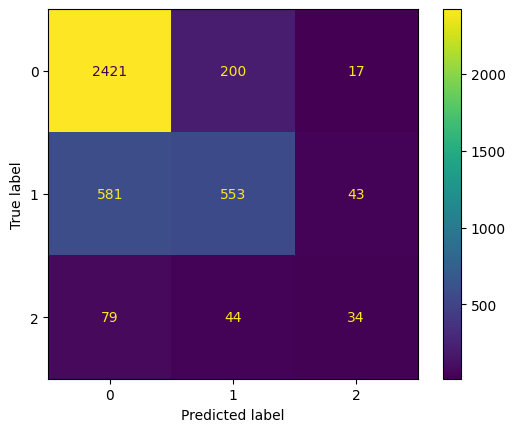

In [ ]:
#predicting using the validation set using the model created
y_pred_lgb = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_labels = np.argmax(y_pred_lgb, axis =1)

#model evaluation using classification report, accuracy and confusion matrix
accuracy = classification_report(y_val, y_pred_labels)
print(f"Accuracy: {accuracy}", accuracy_score(y_val, y_pred_labels) )

confusion_matrix = metrics.confusion_matrix(y_val, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()

### Results and Analysis
The table below shows the different classification algorithms that were used in this experiment and the corresponding accuracies. It is shown that the highest accuracy is the model with **Light Gradient Boost Machine** algorithm.

|Model | Classification Algorithm |Accuracy|
|------|--------------------------|--------|
|M1    |SVM | 0.697 |
|M2    |Decision Tree Classifier | 0.64 |
|M3    |Random Forest Classifier | 0.713 |
|**M4**    |**Light Gradient Boost Machine**| **0.757** |





As shown in the table below, several text preprocessing techniques were explored but the preprocessing techniques with the highest accuracy involved the tweet tokenisation, lemmatisation, Emoji handling, punctuation removal, tf-idf vectorisation and oversampling.

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M1    |tokenisation| Count Vectorizer(1-grams) | 0.741 |
|M2    |tokenisation, lemmatisation| Count Vectorizer(1-grams) | 0.747 |
|M3    |tokenisation, lemmatisation, NER | Count Vectorizer(1-grams) | 0.744 |
|M4    |tokenisation, lemmatisation, Emoji handling | Count Vectorizer(1-grams) | 0.747 |
|M5    |tokenisation, lemmatisation, Emoji handling, punctuation removal | Count Vectorizer(1-grams) | 0.748 |
|M6    |tokenisation, lemmatisation, Emoji handling, punctuation removal | tf-idf vector(1-grams) | 0.748 |
|**M7**    |**tokenisation, lemmatisation, Emoji handling, punctuation removal** | **tf-idf vector(1-grams), oversampling** | **0.757** |




### **Conclusion**

In this sentiment analysis experiment, classification of tweets into three categories: not insulting, targeted insult, and untargeted insult were explored.

Our analysis involved comprehensive preprocessing techniques, including tweet tokenisation, lemmatisation, removal of special characters and punctuations, and handling of emojis. These preprocessing steps were crucial in preparing the textual data for modeling, ensuring that the models could effectively capture the underlying sentiment conveyed in the tweets.

Among the models tested, Light Gradient Boost Machine (LightGBM) emerged as the top performer, achieving the highest accuracy in classifying tweet sentiments with an accuracy of 0.757.

### **References**

Ahuja, R., Chug, A., Kohli, S., Gupta, S. and Ahuja, P., 2019. The impact of features extraction on the sentiment analysis. Procedia Computer Science, 152, pp.341-348.

Fan, J., Ma, X., Wu, L., Zhang, F., Yu, X. and Zeng, W., 2019. Light Gradient Boosting Machine: An efficient soft computing model for estimating daily reference evapotranspiration with local and external meteorological data. Agricultural water management, 225, p.105758.

Fromknecht, J. and Palmer, A., 2020, December. UNT Linguistics at SemEval-2020 Task 12: Linear SVC with Pre-trained Word Embeddings as Document Vectors and Targeted Linguistic Features. In Proceedings of the Fourteenth Workshop on Semantic Evaluation (pp. 2209-2215).

Jiang, L. and Suzuki, Y., 2019, November. Detecting hate speech from tweets for sentiment analysis. In 2019 6th International conference on systems and informatics (ICSAI) (pp. 671-676). IEEE.

Li, Y, Ma J., Xiao J., Wang Y., and He W., (2024) Use of extreme gradient boosting, light gradient boosting machine, and deep neural networks to evaluate the activity stage of extraocular muscles in thyroid-associated ophthalmopathy. Graefe’s archive for clinical and experimental ophthalmology. [Online] 262 (1), 203–210.

Mahata, D., Zhang, H., Uppal, K., Kumar, Y., Shah, R., Shahid, S., Mehnaz, L. and Anand, S., 2019, June. MIDAS at SemEval-2019 task 6: Identifying offensive posts and targeted offense from twitter. In Proceedings of the 13th International Workshop on Semantic Evaluation (pp. 683-690).

Python.org. (2020). The Python Standard Library — Python 3.8.1 documentation. [online] Available at: https://docs.python.org/3/library/.

Ranasinghe, T. and Hettiarachchi, H., 2019. Emoji powered capsule network to detect type and target of offensive posts in social media.

Rosenthal, S., Atanasova, P., Karadzhov, G., Zampieri, M. and Nakov, P., 2020. A large-scale semi-supervised dataset for offensive language identification. arXiv preprint arXiv:2004.14454.

Tabassum, A. and Patil, R.R., 2020. A survey on text pre-processing & feature extraction techniques in natural language processing. International Research Journal of Engineering and Technology, June.
